# Introduction 
This repository contains test task for Data Scientists

# Task description

We had several measurements (MFL) of the pipe defects.

Each measurement has 3 channels.

Each measurement (defect) belongs to one of two defect location ( internal and external , or ID and OD).
Also, each defect belongs to different sub-type (i.e, corrosion, dent, gouge, etc.)

Candidate should:

1. Perform EDA. Draw conclusions.

2. On the basis of provided data, train classifier that will predict defect location for unlabeled data.
Scoring - F1 

Goal is to get F1 >0.8

3. Perform unsupervised clustering. 
Identify optimal number of clusters.
Draw most typical representative of each identified class.

In [40]:
import pandas as pd
import numpy as np
from scipy.stats import skew, kurtosis
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score 
import matplotlib.pyplot as plt

Выполним загрузку данных и проведем анализ сырых данных, то есть посмотрим столбцы, типы данных, наличие пропусков, посмотрим базовую структуру и порядок величин. По полученной информации сделаю первоначальные выводы 

In [41]:
df_data = pd.read_csv("data.csv")
df_target = pd.read_csv("target_train.csv")


print("Проверим какие столбцы есть в файле с данными")
print(df_data.info())
print("\nПосмотрим на порядок данных")
print(df_data.describe())
print("\nШапка")
print(df_data.head())
print("\nПроверка пропусков")
print(df_data.isnull().sum())



Проверим какие столбцы есть в файле с данными
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 588000 entries, 0 to 587999
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Unnamed: 0  588000 non-null  int64  
 1   id          588000 non-null  object 
 2   time        588000 non-null  int64  
 3   ch0         588000 non-null  float64
 4   ch1         588000 non-null  float64
 5   ch2         588000 non-null  float64
dtypes: float64(3), int64(2), object(1)
memory usage: 26.9+ MB
None

Посмотрим на порядок данных
          Unnamed: 0           time            ch0            ch1  \
count  588000.000000  588000.000000  588000.000000  588000.000000   
mean     1199.500000    1199.500000     373.567190     334.273639   
std       692.820852     692.820852     157.455531     117.087441   
min         0.000000       0.000000   -6801.811171   -6801.811171   
25%       599.750000     599.750000     359.937584     330.036227 

У нас есть, полный набор данных, представляющий собой 245 уникальных временных сигналов длиной в 2400 шагов каждый, количество временных сигналов можно вычислить из данных count и max по time. Данные требуют минимальной очистки- удаление лишнего столбца, так как столбец unnamed не несет в себе смысла ввиду того что полностью дублирует столбец time по describe. Три измерительных канала (ch0, ch1, ch2) имеют разные характеристики, что говорит о необходимости их раздельного анализа. Данные не имеют пропусков, в заполнении не нуждаются. Следующим шагом я проведу генерацию данных по новым основным статистическим признакам для каждого канала по каждому уникальному id.

In [42]:
def create_features(df):
    grouped = df.groupby("id")
    features_list = []

    for name, group in grouped:
        features = {"id": name}
        for ch in ["ch0", "ch1", "ch2"]:
            signal = group[ch]
            features[f"{ch}_mean"] = signal.mean()
            features[f"{ch}_std"] = signal.std()
            features[f"{ch}_min"] = signal.min()
            features[f"{ch}_max"] = signal.max()
            features[f"{ch}_median"] = signal.median()
            features[f"{ch}_skew"] = skew(signal)
            features[f"{ch}_kurtosis"] = kurtosis(signal)
        features_list.append(features)

    return pd.DataFrame(features_list)


print("Генерация признаков")
df_features = create_features(df_data)

Генерация признаков


Посмотрим не выдала ли функция генерации новых признаков ошибок или пропусков, также проанализируем масштабность данных

In [43]:
print("Посмотрим на порядок данных после генерации признаков")
print(df_features.describe())
print("\nПроверка пропусков генерации признаков")
print(df_features.isnull().sum())

Посмотрим на порядок данных после генерации признаков
         ch0_mean     ch0_std      ch0_min      ch0_max  ch0_median  \
count  245.000000  245.000000   245.000000   245.000000  245.000000   
mean   373.567190  119.250210  -328.647950  1124.910406  371.651746   
std      3.729474  103.011541  1091.588900   765.375689    5.495590   
min    342.013122   16.256450 -6801.811171   414.881328  352.462245   
25%    373.141837   57.261173  -295.649667   645.121776  369.281758   
50%    373.843428   82.724577    44.104501   814.811977  372.271894   
75%    374.596569  139.531046   198.844024  1286.879650  375.262030   
max    385.785438  673.136148   311.347879  4221.324067  384.606204   

         ch0_skew  ch0_kurtosis    ch1_mean     ch1_std      ch1_min  ...  \
count  245.000000    245.000000  245.000000  245.000000   245.000000  ...   
mean     1.045646     32.632423  334.273639   80.844998  -380.537483  ...   
std      3.956213     41.638076   18.412283   82.882545  1102.558494  ...  

Функция генерации признаков нигде не создала ошибку, пропуски не появились в новых признаках, можно отметить что в признаках есть большие разницы по разрядности данных, значит необходимо будет выполнить масштабирование данных при обучении модели

Создадим тренировочные данные по новым признакам сопоставив исходные тренировочные данные с новыми данными сгенерированных признаков и проведем анализ тренировочного набора по новым признакам, для отбора наиболее значимых в обучении признаков


Статистика
         ch0_mean     ch0_std      ch0_min      ch0_max  ch0_median  \
count  100.000000  100.000000   100.000000   100.000000  100.000000   
mean   373.682740  110.948994  -311.736597  1046.779229  372.355992   
std      2.626364   91.180065  1066.808723   666.318592    5.325583   
min    360.684339   16.256450 -6481.866652   414.881328  352.462245   
25%    373.086472   58.180760  -285.651401   640.449689  370.309617   
50%    373.749831   78.223592    27.845639   825.838102  373.019428   
75%    374.353503  120.182131   192.676869  1158.116931  375.635797   
max    383.836244  505.992546   311.347879  3605.729881  381.242301   

         ch0_skew  ch0_kurtosis    ch1_mean     ch1_std      ch1_min  ...  \
count  100.000000    100.000000  100.000000  100.000000   100.000000  ...   
mean     0.729812     36.642833  334.043632   75.516619  -353.957313  ...   
std      4.397130     52.736539   19.868003   73.205938  1060.614896  ...   
min    -18.022961     -0.669558  234.369

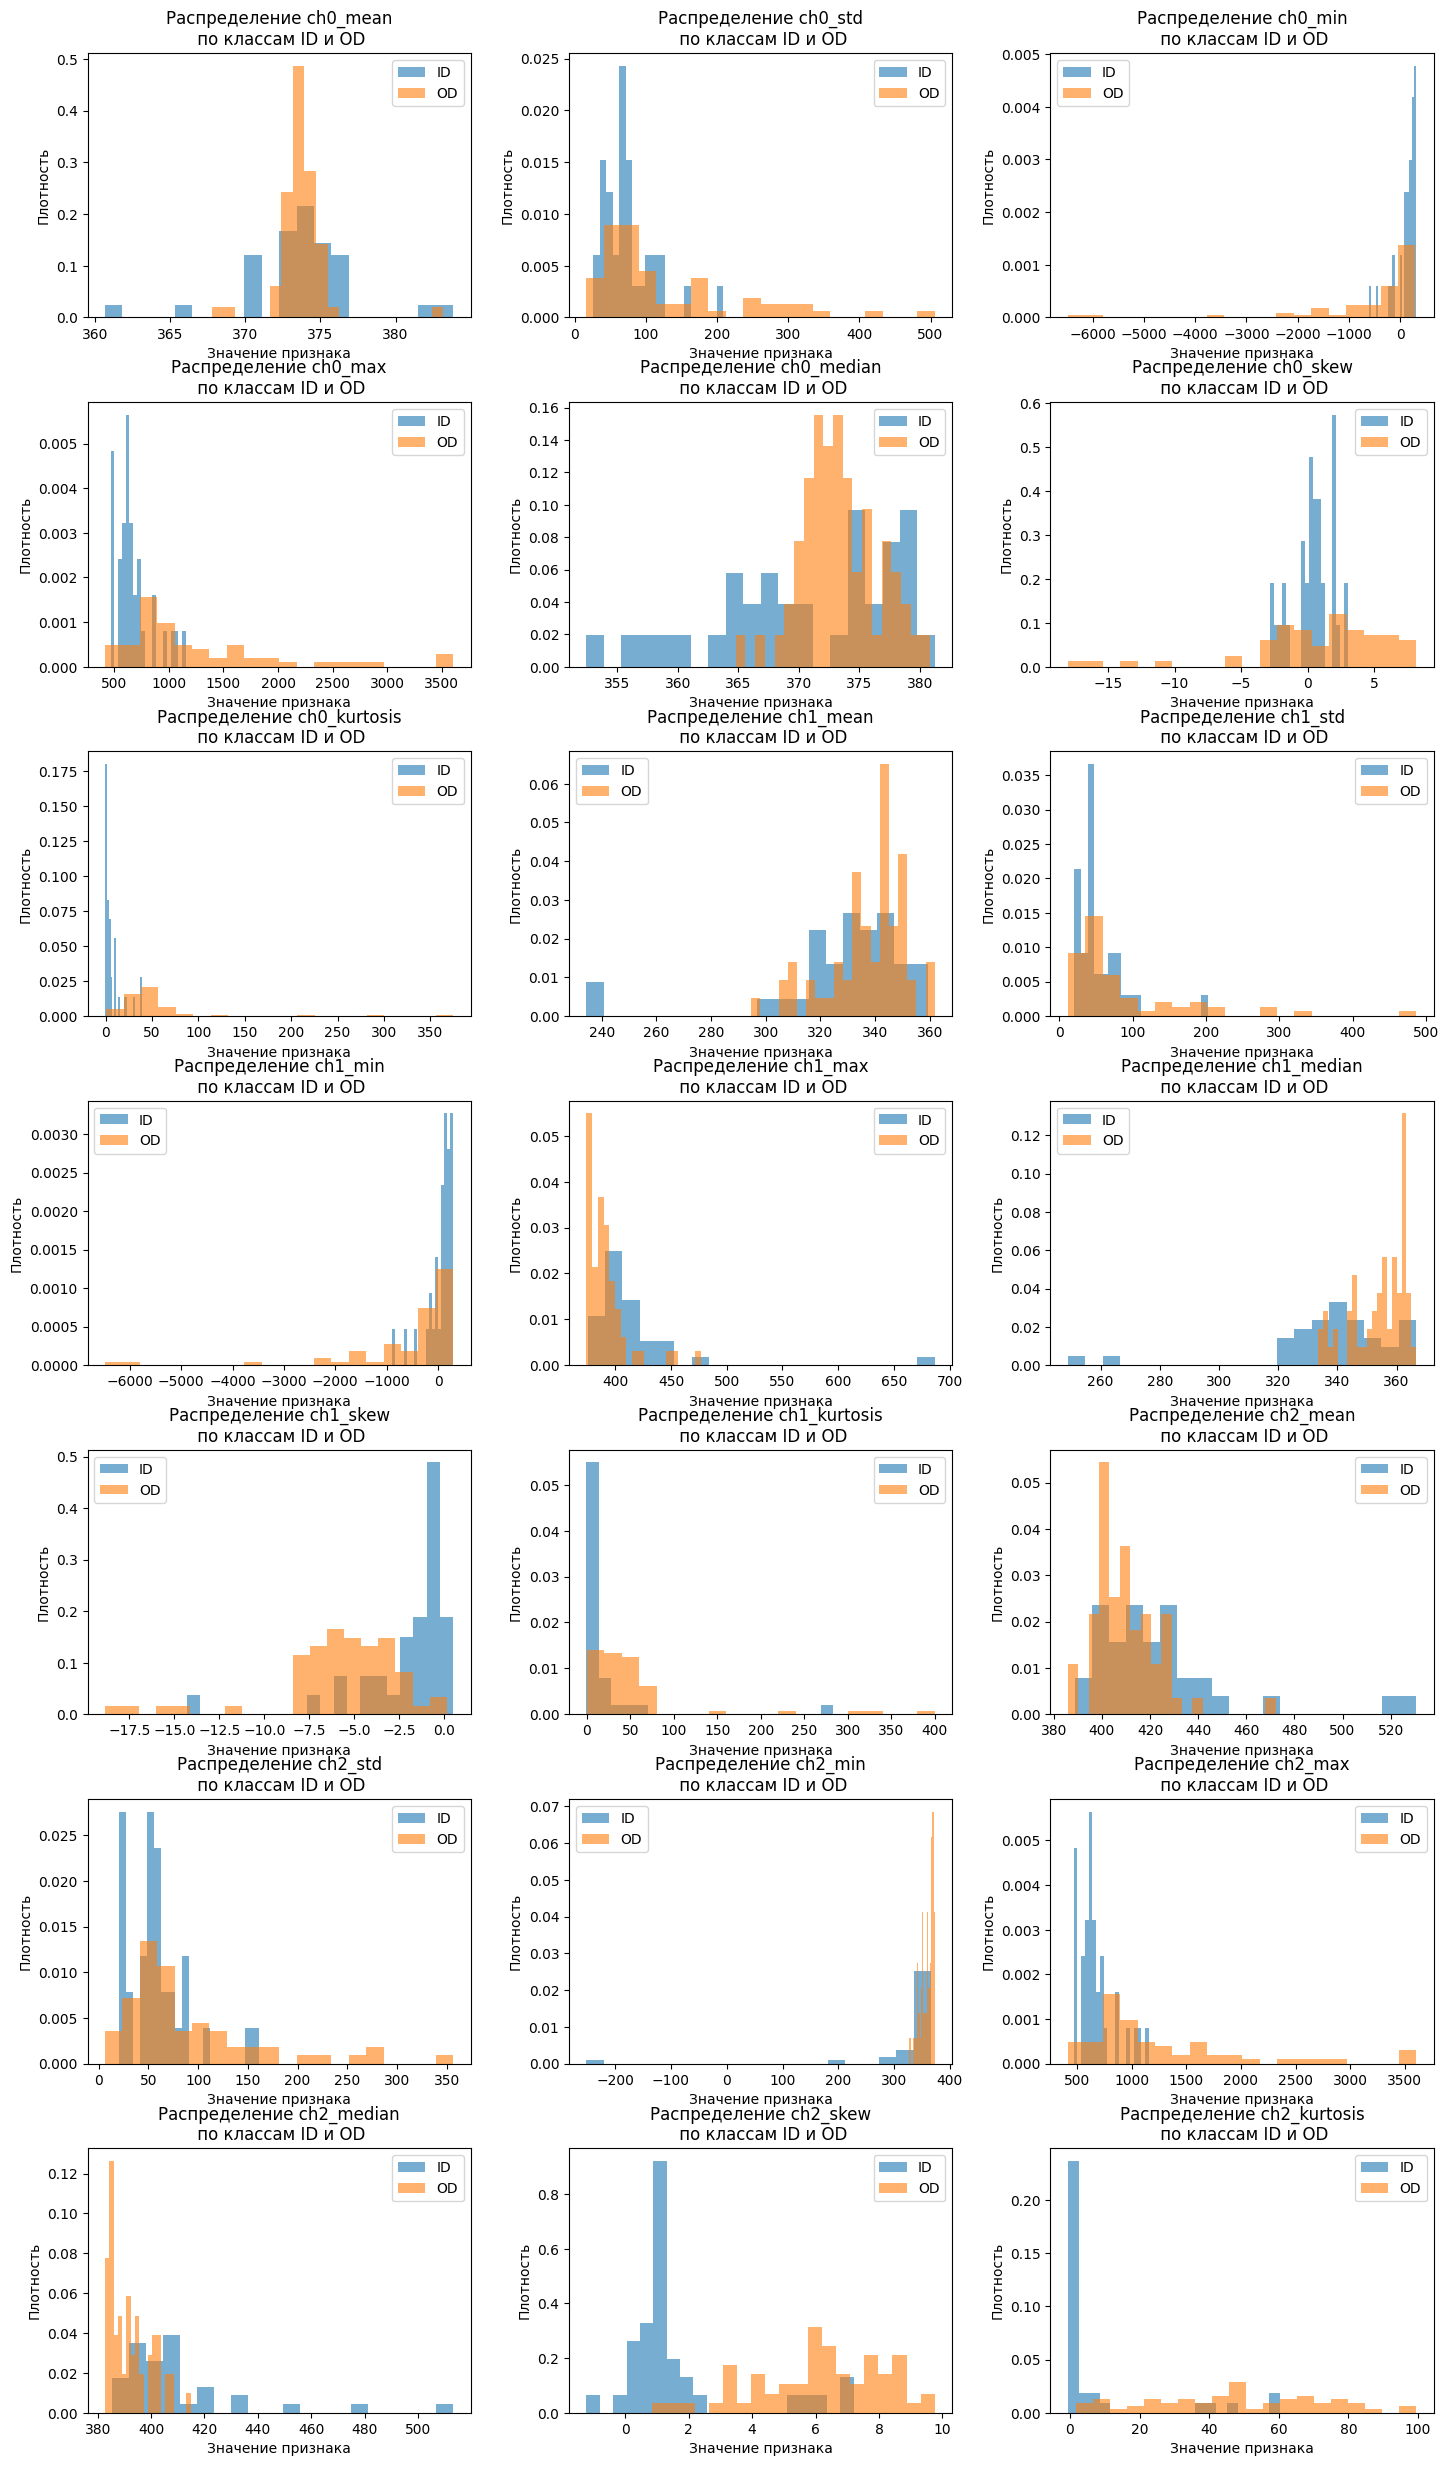

In [44]:
df_train = pd.merge(df_features, df_target, on="id", how="inner")


print("\nСтатистика")
print(df_train.describe())
print("\nБаланс классов")
print(df_train["target"].value_counts())
print("\nПроверка пропусков:")
print(df_train.isnull().sum())


fig, axes = plt.subplots(nrows=7, ncols=3, figsize=(15, 25))
fig.tight_layout(pad=4.0)
feature_columns = df_train.drop(columns=['id', 'target']).columns.tolist()
for i, feature in enumerate(feature_columns):
    ax = axes.flatten()[i]
    ax.hist(df_train[df_train['target'] == 'ID'][feature], bins=20, alpha=0.6, label='ID', density=True)
    ax.hist(df_train[df_train['target'] == 'OD'][feature], bins=20, alpha=0.6, label='OD', density=True)
    
    ax.set_title(f'Распределение {feature}\n по классам ID и OD')
    ax.set_xlabel('Значение признака')
    ax.set_ylabel('Плотность')
    ax.legend() 

plt.show()


После создания тренировочного набора никаких ошибок не возникло, пропуски не появились.
По количеству классов target необходимо из-за различия в количестве произвести балансировку.
Построили гистограмму по всем созданным признакам по классам ID и OD, необходимо выбрать наиболее значимые признаки, для этого выберем признаки в которые наибольшая разница вершин по плотности и оставим только их в дальнейшем обучении модели для исключения переобучения.
Наибольшее различие создают признаки skew и kurtosis, оставим только их и выполним обучение модели на отобранных признаках. Также из предыдущих анализов мы выяснили что необходимо провести масштабирование и балансировку

Проведем генерацию признаков по новым отобранным критериям, создадим новый тренировочный набор данный по отобранным признакам, выполним балансировку и масштабирование данных, а также обучим модель несколькими способами классического ML, используем RandomForestClassifier, HistGradientBoostingClassifier, LogisticRegression

In [45]:
def create_features_new(df):
    grouped = df.groupby("id")
    features_list = []

    for name, group in grouped:
        features = {"id": name}
        for ch in ["ch0", "ch1", "ch2"]:
            signal = group[ch]
            features[f"{ch}_skew"] = skew(signal)
            features[f"{ch}_kurtosis"] = kurtosis(signal)
        features_list.append(features)

    return pd.DataFrame(features_list)


print("Генерация отобранных признаков")
df_features_new = create_features_new(df_data)
df_train_new = pd.merge(df_features_new, df_target, on="id", how="inner")



#Делим на признаки и классы
X = df_train_new.drop(columns=["id", "target"])
y_raw = df_train_new["target"]

#Кодируем классы для исчезновения string данных
le = LabelEncoder()
y = le.fit_transform(y_raw)

#Масштабируем признаки
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Обучение моделей ")

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
models = {
    "RandomForest": RandomForestClassifier(
        class_weight="balanced", random_state=42, n_estimators=1000
    ),
    "HistGradientBoosting": HistGradientBoostingClassifier(random_state=42),
    "LogisticRegression": LogisticRegression(class_weight="balanced", max_iter=1000, random_state=42)
}

results = {}
for name, model in models.items():
    scores = cross_val_score(model, X_scaled, y, cv=cv, scoring="f1_weighted")
    results[name] = scores.mean()

for key, value in results.items():
        print(f"Модель: {key}, F1-score: {value}")

Генерация отобранных признаков
Обучение моделей 
Модель: RandomForest, F1-score: 0.9074489954489955
Модель: HistGradientBoosting, F1-score: 0.8869712509712511
Модель: LogisticRegression, F1-score: 0.8984380064380065


Ошибок с данными не произошло, модели успешно обучились на новых отобранных по гистограммам данным, поставленная цель по F1-score > 0.8 выполнена для каждой из моделей

Используем алгоритм Kmeans и построение графика методом локтя чтобы вычислить оптимальное количество кластеров для дальнейшего вычисления представителей кластеров

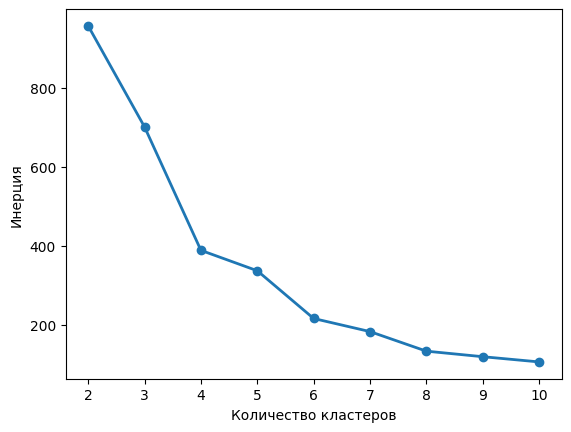

In [46]:
X_cluster = df_features_new.drop(columns=['id', 'clusters'], errors='ignore') 
X_scaled = StandardScaler().fit_transform(X_cluster)

k_range = range(2, 11) 
inertias = []
scores = []
for k in k_range:
    kmeans_model = KMeans(n_clusters=k, n_init='auto', random_state=42).fit(X_scaled)
    inertias.append(kmeans_model.inertia_)
    scores.append(silhouette_score(X_scaled, kmeans_model.labels_))

plt.plot(k_range, inertias, 'o-', linewidth=2)
plt.xlabel('Количество кластеров')
plt.ylabel('Инерция')
plt.show()

Анализируя график, построенные методом локтя, выбираем оптимальное количество кластеров - 3
Проведем кластеризацию, выявим типичных представителей. В каждом кластере найдем центроид который хранится после выполнения алгоритма Kmeans, после чего найдем типичного представителя путем нахождения элемента который находится на минимальном расстоянии от центроида в данном кластере и выведем его.

In [47]:
NEW_K = 4

kmeans = KMeans(n_clusters=NEW_K, n_init='auto', random_state=42).fit(X_scaled)
df_features_new["cluster"] = kmeans.labels_

print(f"Количество элементов в каждом кластере:\n{df_features_new['cluster'].value_counts()}")
print("\nТипичные представители")

representative_ids = []
for i in range(NEW_K):
    cluster_points_scaled = X_scaled[df_features_new.cluster == i]
    closest_point_idx_in_cluster = np.argmin(np.linalg.norm(cluster_points_scaled - kmeans.cluster_centers_[i], axis=1))
    typical_id = df_features_new[df_features_new.cluster == i].iloc[closest_point_idx_in_cluster]["id"]
    representative_ids.append(typical_id)
    print(f"Кластер {i}: типичный id = {typical_id}")
    


for rep_id in representative_ids:
    sample_features = df_features_new[df_features_new['id'] == rep_id]
    print(f"\nid = {rep_id} (Кластер {sample_features['cluster'].iloc[0]})")
    print(sample_features.drop(columns=['id', 'cluster']).iloc[0])





Количество элементов в каждом кластере:
cluster
1    88
0    82
2    68
3     7
Name: count, dtype: int64

Типичные представители
Кластер 0: типичный id = 155_1
Кластер 1: типичный id = 111_1
Кластер 2: типичный id = 88_2
Кластер 3: типичный id = 148_2

id = 155_1 (Кластер 0)
ch0_skew        0.973427
ch0_kurtosis    3.744779
ch1_skew       -1.003677
ch1_kurtosis    0.680532
ch2_skew        1.185543
ch2_kurtosis    1.068996
Name: 68, dtype: float64

id = 111_1 (Кластер 1)
ch0_skew        -0.325048
ch0_kurtosis    24.417106
ch1_skew        -7.135604
ch1_kurtosis    53.820301
ch2_skew         6.212867
ch2_kurtosis    40.382459
Name: 24, dtype: float64

id = 88_2 (Кластер 2)
ch0_skew         6.257957
ch0_kurtosis    50.772550
ch1_skew        -4.507340
ch1_kurtosis    28.064422
ch2_skew         7.792212
ch2_kurtosis    64.753515
Name: 226, dtype: float64

id = 148_2 (Кластер 3)
ch0_skew        -13.994825
ch0_kurtosis    217.029353
ch1_skew        -14.878065
ch1_kurtosis    235.632531
ch2_sk

Как можно отметить у каждого кластера есть типичные особенности в отдельно выбранных признаках для лучшего обучения